* https://github.com/ndb796/LatentHSJA
* https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA

download CelebA_HQ_facial_identity_dataset.zip

In [1]:
import glob
import pandas as pd
import shutil
import os
import tqdm

In [2]:
# We have a dataset with the following directory structure train/*/*.jpg and test/*/*.jpg

In [3]:
base_dir = "/projects/leelab3/chanwkim/data_attribution/datasets/"

In [14]:
train_images = glob.glob(base_dir + "train/*/*.jpg")

In [15]:
test_images = glob.glob(base_dir + "test/*/*.jpg")

In [16]:
len(train_images), len(test_images)

(4263, 1215)

In [18]:
# move to a same directory
import shutil
import os

os.makedirs(base_dir+"celeba_hq_256_curated", exist_ok=True)
for image in tqdm.tqdm(train_images):
    # rename to */*.jpg to *_*.jpg
    new_image = "/".join(image.split("/")[-2:]).replace("/", "_")
    shutil.copy(image, os.path.join(base_dir + "celeba_hq_256_curated", new_image))

for image in tqdm.tqdm(test_images):
    # rename to */*.jpg to *_*.jpg
    new_image = "/".join(image.split("/")[-2:]).replace("/", "_")
    shutil.copy(
        image,
        os.path.join(base_dir + "celeba_hq_256_curated", new_image),
    )

100%|██████████| 1215/1215 [00:46<00:00, 26.09it/s]


In [19]:
assert (len(train_images) + len(test_images)) == len(
    glob.glob(base_dir + "celeba_hq_256_curated/*.jpg")
)

In [20]:
df_train=pd.DataFrame({
    "image_path":[x.split("/")[-1] for x in train_images],
    "label":[int(image.split("/")[-2]) for image in train_images],})

df_test = pd.DataFrame(
    {
        "image_path": [x.split("/")[-1] for x in test_images],
        "label": [int(image.split("/")[-2]) for image in test_images],
    }
)

In [27]:
# make a dataframe with the following columns: image_path, label, split
all_images = glob.glob(base_dir + "celeba_hq_256_curated/*.jpg")
df = pd.DataFrame(
    {
        "filename": [x.split("/")[-1] for x in all_images],
        "celeb": [x.split("/")[-1].split("_")[0] for x in all_images],
        "split": [
            (
                "train"
                if x.split("/")[-1]
                in set(df_test["label"].astype(str) + "_" + df_test["image_path"])
                else "test"
            )
            for x in all_images
        ],
    }
)

In [29]:
df

filename celeb  split
0      1550_5862.jpg  1550  train
1       982_9641.jpg   982  train
2      1269_9713.jpg  1269  train
3     2076_14576.jpg  2076   test
4       805_7036.jpg   805  train
...              ...   ...    ...
5473   560_26861.jpg   560   test
5474    195_5281.jpg   195  train
5475   1538_4254.jpg  1538   test
5476   1027_1636.jpg  1027   test
5477    628_1932.jpg   628   test

[5478 rows x 3 columns]

In [30]:
df.to_csv(base_dir + "celeba_hq_256_curated/labels.csv", index=False)

In [44]:
# number-based sampling
num_threshold=0
label_counts=df["celeb"].value_counts().sort_values(ascending=False)
label_counts = label_counts[label_counts > num_threshold]

# sample 50 labels
label_counts=label_counts.sample(50, random_state=44)

df_filtered = df[df["celeb"].isin(label_counts.index)]

df_filtered

filename celeb  split
1       982_9641.jpg   982  train
4       805_7036.jpg   805  train
13    2214_16719.jpg  2214   test
17      615_8231.jpg   615  train
19     228_21802.jpg   228   test
...              ...   ...    ...
5451    188_6642.jpg   188  train
5453  1293_23808.jpg  1293   test
5459     95_1413.jpg    95   test
5462   452_10823.jpg   452   test
5475   1538_4254.jpg  1538   test

[895 rows x 3 columns]

In [53]:
len(label_counts), len(df_filtered)

(50, 895)

In [ ]:
# plot 10 images per label
import matplotlib.pyplot as plt
import numpy as np

num_rows = 50
num_samples = 10

fig, axes = plt.subplots(num_rows, num_samples, figsize=(1 * num_samples, 1 * num_rows))
for i, (label, group) in enumerate(df_filtered.groupby("celeb")):
    for j, (_, row) in enumerate(group.sample(num_samples).iterrows()):
        ax = axes[i, j]
        ax.imshow(
            plt.imread(
                base_dir + "celeba_hq_256_curated" + "/" + row["filename"]
            )
        )
        ax.axis("off")
        ax.set_title(f"label: {label} - n=" + str(len(group)), fontdict={"fontsize": 4})
    if i == num_rows - 1:
        break
# save fig
fig.savefig(
    base_dir + "celeba_hq_256_curated/celeba_hq_256_curated_sampled.png", dpi=300
)

# close fig
plt.close(fig)

In [47]:
directory = base_dir + "celeba_hq_256_50_resized/"
shutil.rmtree(directory)

In [50]:
os.makedirs(base_dir + "celeba_hq_256_50_resized", exist_ok=True)
df_filtered.to_csv(base_dir + "celeba_hq_256_50_resized/labels.csv", index=False)

In [51]:
from PIL import Image
import albumentations
import numpy as np

Resizing
* https://github.com/CompVis/latent-diffusion/blob/main/configs/latent-diffusion/celebahq-ldm-vq-4.yaml
* https://github.com/CompVis/taming-transformers/blob/master/taming/data/faceshq.py#L29C1-L29C6

* https://github.com/CompVis/latent-diffusion/blob/main/configs/autoencoder/autoencoder_kl_64x64x3.yaml#L36
* https://github.com/CompVis/latent-diffusion/blob/main/ldm/data/imagenet.py#L319

In [52]:
for idx, row in df_filtered.iterrows():
    path = base_dir + "celeba_hq_256_curated" + "/" + row["filename"]
    image = Image.open(path)
    size = 256
    rescaler = albumentations.SmallestMaxSize(max_size=size)
    cropper = albumentations.CenterCrop(height=size, width=size)
    preprocessor = albumentations.Compose([rescaler, cropper])
    image = np.array(image).astype(np.uint8)
    image_new = preprocessor(image=image)
    Image.fromarray(image_new["image"]).save(
        path.replace("celeba_hq_256_curated", "celeba_hq_256_50_resized")
    )    

# plot

In [7]:
df_filtered=pd.read_csv(base_dir + "celeba_hq_256_50_resized/labels.csv")

In [8]:
df_filtered

filename  celeb  split
0      982_9641.jpg    982  train
1      805_7036.jpg    805  train
2    2214_16719.jpg   2214   test
3      615_8231.jpg    615  train
4     228_21802.jpg    228   test
..              ...    ...    ...
890    188_6642.jpg    188  train
891  1293_23808.jpg   1293   test
892     95_1413.jpg     95   test
893   452_10823.jpg    452   test
894   1538_4254.jpg   1538   test

[895 rows x 3 columns]

In [11]:
# plot 10 images per label
import matplotlib.pyplot as plt
import numpy as np

num_rows = 50
num_samples = 10

fig, axes = plt.subplots(num_rows, num_samples, figsize=(1 * num_samples, 1 * num_rows))
for i, (label, group) in enumerate(df_filtered.groupby("celeb")):
    for j, (_, row) in enumerate(group.sample(num_samples).iterrows()):
        ax = axes[i, j]
        ax.imshow(
            plt.imread(
                base_dir + "celeba_hq_256_50_resized" + "/" + row["filename"]
            )
        )
        ax.axis("off")
        ax.set_title(f"label: {label} - n=" + str(len(group)), fontdict={"fontsize": 4})
    if i == num_rows - 1:
        break
# save fig
fig.savefig(
    base_dir + "celeba_hq_256_50_resized.png", dpi=300
)

# close fig
plt.close(fig)

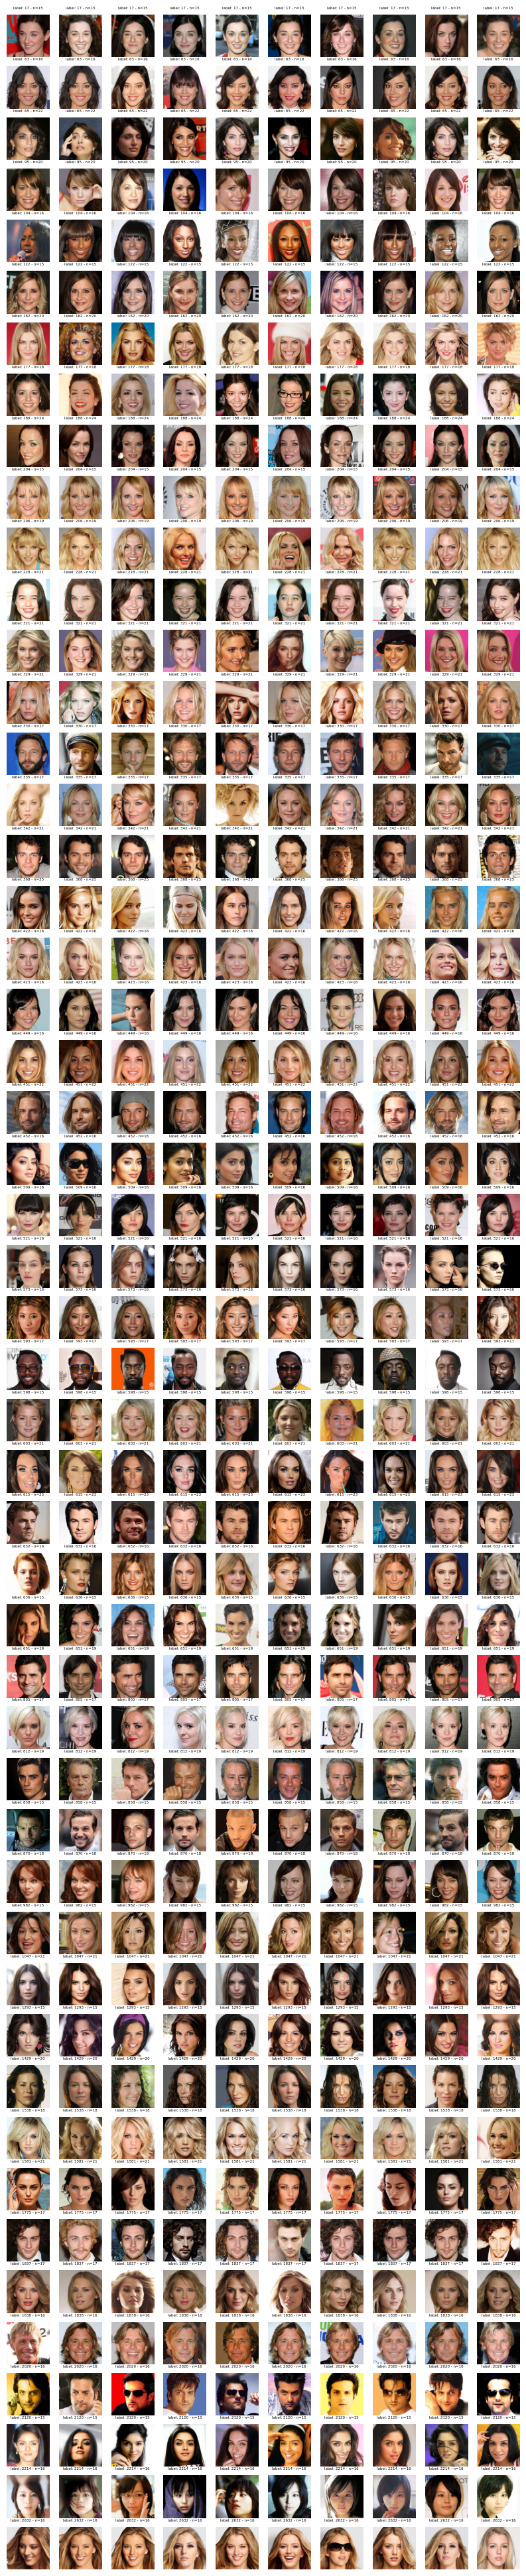

In [14]:
fig

In [ ]:
104, 593, 603, 2120

In [29]:
!ls /projects/leelab3/chanwkim/data_attribution/datasets/celeba_hq_256_50_resized_temp | wc -l

896


In [59]:
base_dir

'/projects/leelab3/chanwkim/data_attribution/datasets/'

* hair color
* curly hair
* hair length
* eye color
* beard
* gender

---
* ethnicity all white?

tar the directory base_dir + "celeba_hq_256_50_resized" only include the "/celeba_hq_256_50_resized/.jpg"

```bash
cd /projects/leelab3/chanwkim/data_attribution/datasets/
tar -czvf celeba_hq_256_50_resized.tar.gz celeba_hq_256_50_resized/
```

using sftp, send to  host "klone-login' directory: /gscratch/aims/datasets/
```bash
scp /projects/leelab3/chanwkim/data_attribution/datasets//celeba_hq_256_50_resized.tar.gz chanwkim@klone-login:/gscratch/aims/datasets/
```

```bash
ssh chanwkim@klone-login
cd /gscratch/aims/datasets/
tar -xzvf celeba_hq_256_50_resized.tar.gz
```